In [1]:
dataset_directory = '../dataset'
validation_directory = dataset_directory + '/validation'
train_directory = dataset_directory + '/train'

In [2]:
from keras.utils import image_dataset_from_directory

image_size = (256, 256)

train_dataset = image_dataset_from_directory(
    train_directory,
    label_mode = 'categorical',
    image_size = image_size,
    batch_size = 8,
    shuffle = True
)

validation_dataset = image_dataset_from_directory(
    validation_directory,
    label_mode = 'categorical',
    image_size = image_size,
    batch_size = 8,
    shuffle = True
)

Found 17208 files belonging to 3 classes.
Found 1000 files belonging to 3 classes.


In [3]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
from keras.applications import VGG16

base_model = VGG16 (
    weights = 'imagenet',
    include_top = False,
    input_shape = image_size + (3,)
)

base_model.trainable = False

In [5]:
from keras.models import Sequential
from keras.layers import InputLayer, Rescaling, RandomFlip, RandomRotation, GlobalAveragePooling2D, Flatten, BatchNormalization, Dropout, Dense, Rescaling, RandomFlip, RandomRotation

model = Sequential (
    [
        InputLayer(input_shape = image_size + (3,)),

        Rescaling(1./255),
        RandomFlip('horizontal_and_vertical'),
        RandomRotation(factor=0.4, fill_mode='wrap'),

        base_model,

        GlobalAveragePooling2D(),
        Flatten(),

        Dense(64, activation='elu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(64, activation='elu', kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(3, activation='softmax')
    ]
)

In [6]:
from keras.optimizers import Adam

model.compile (
    optimizer = Adam(),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

In [7]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath = '../models/vgg-16-model.keras',
    monitor ='val_categorical_accuracy',
    verbose = True,
    save_best_only = True,
    save_weights_only=False,
    mode = 'max'
)

In [8]:
history = model.fit(
    train_dataset,
    epochs = 5,
    validation_data = validation_dataset,
    callbacks = [checkpoint]
)

Epoch 1/5
2151/2151 [==============================] - ETA: 0s - loss: 0.4160 - categorical_accuracy: 0.8384
Epoch 1: val_categorical_accuracy improved from -inf to 0.69300, saving model to ../models\vgg-16-model.keras
2151/2151 [==============================] - 370s 163ms/step - loss: 0.4160 - categorical_accuracy: 0.8384 - val_loss: 0.8383 - val_categorical_accuracy: 0.6930
Epoch 2/5
2151/2151 [==============================] - ETA: 0s - loss: 0.3221 - categorical_accuracy: 0.8807
Epoch 2: val_categorical_accuracy improved from 0.69300 to 0.70800, saving model to ../models\vgg-16-model.keras
2151/2151 [==============================] - 281s 131ms/step - loss: 0.3221 - categorical_accuracy: 0.8807 - val_loss: 0.8308 - val_categorical_accuracy: 0.7080
Epoch 3/5
2151/2151 [==============================] - ETA: 0s - loss: 0.3032 - categorical_accuracy: 0.8858
Epoch 3: val_categorical_accuracy improved from 0.70800 to 0.73200, saving model to ../models\vgg-16-model.keras
2151/2151 [====

In [9]:
from keras.models import load_model
model = load_model('../models/vgg-16-model.keras')

In [10]:
start_tunning_at = len(base_model.layers) - int(0.3 * len(base_model.layers))

print(f"Number of layers in the base model: {len(base_model.layers)}")
print(f"Number of layers to be fine-tuned: {len(base_model.layers) - start_tunning_at}")

Number of layers in the base model: 19
Number of layers to be fine-tuned: 5


In [11]:
for layer in base_model.layers[start_tunning_at:]:
    layer.trainable = True

In [12]:
from keras.optimizers import Adam

model.compile (
    optimizer = Adam(),
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy']
)

In [13]:
history = model.fit(
    train_dataset,
    epochs = 30,
    validation_data = validation_dataset,
    callbacks = [checkpoint]
)

Epoch 1/30
2151/2151 [==============================] - ETA: 0s - loss: 0.2971 - categorical_accuracy: 0.8909
Epoch 1: val_categorical_accuracy did not improve from 0.88300
2151/2151 [==============================] - 363s 167ms/step - loss: 0.2971 - categorical_accuracy: 0.8909 - val_loss: 0.8860 - val_categorical_accuracy: 0.6680
Epoch 2/30
2151/2151 [==============================] - ETA: 0s - loss: 0.2863 - categorical_accuracy: 0.8925
Epoch 2: val_categorical_accuracy did not improve from 0.88300
2151/2151 [==============================] - 358s 166ms/step - loss: 0.2863 - categorical_accuracy: 0.8925 - val_loss: 0.6584 - val_categorical_accuracy: 0.7640
Epoch 3/30
2151/2151 [==============================] - ETA: 0s - loss: 0.2737 - categorical_accuracy: 0.8982
Epoch 3: val_categorical_accuracy did not improve from 0.88300
2151/2151 [==============================] - 354s 164ms/step - loss: 0.2737 - categorical_accuracy: 0.8982 - val_loss: 0.6895 - val_categorical_accuracy: 0.711

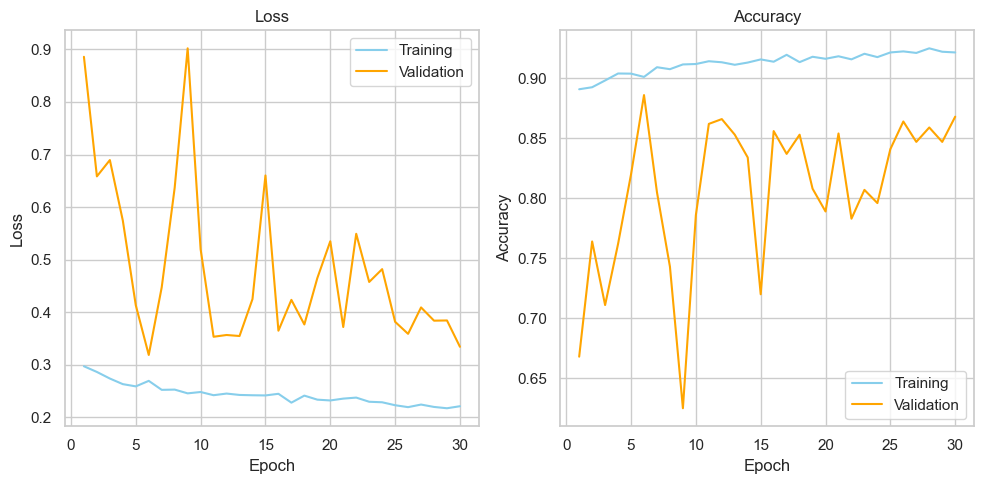

In [14]:
from utils.plot_history import plot_history
plot_history(history)

In [15]:
from keras.models import load_model
model = load_model('../models/vgg-16-model.keras')

1/1 [==============================] - 0s 28ms/step


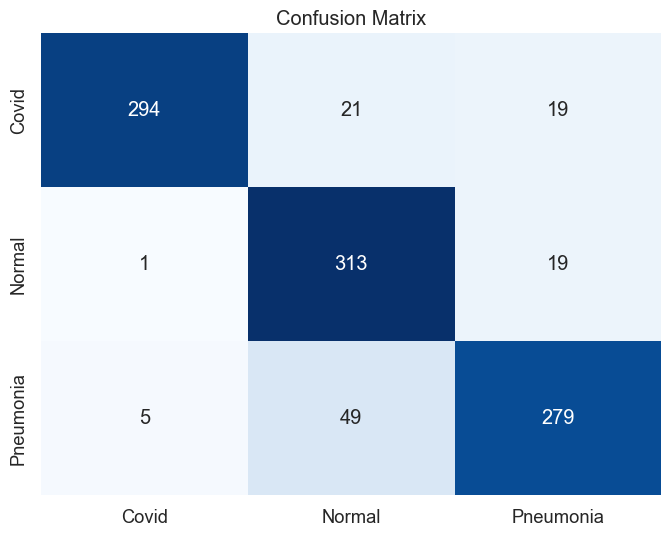

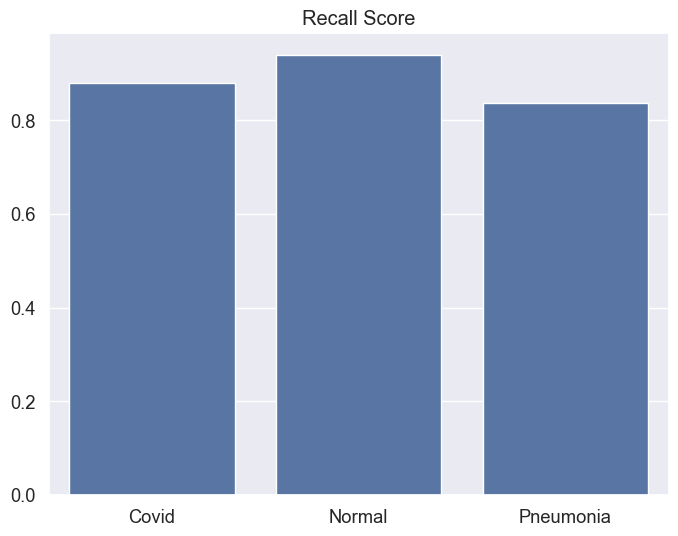

Covid: 0.8802
Normal: 0.9399
Pneumonia: 0.8378


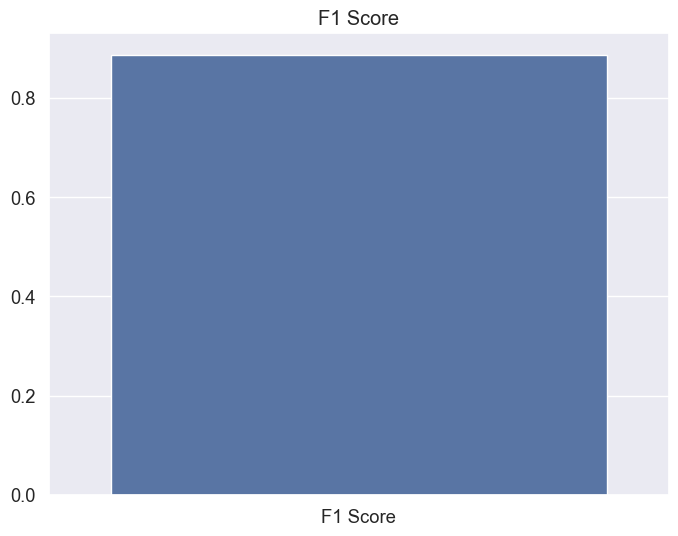

F1-Score: 0.8867


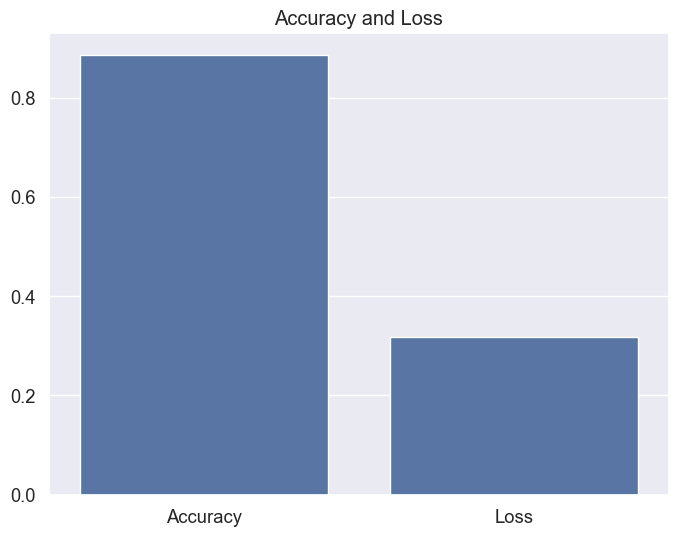

Accuracy: 0.8860 | Loss: 0.3186


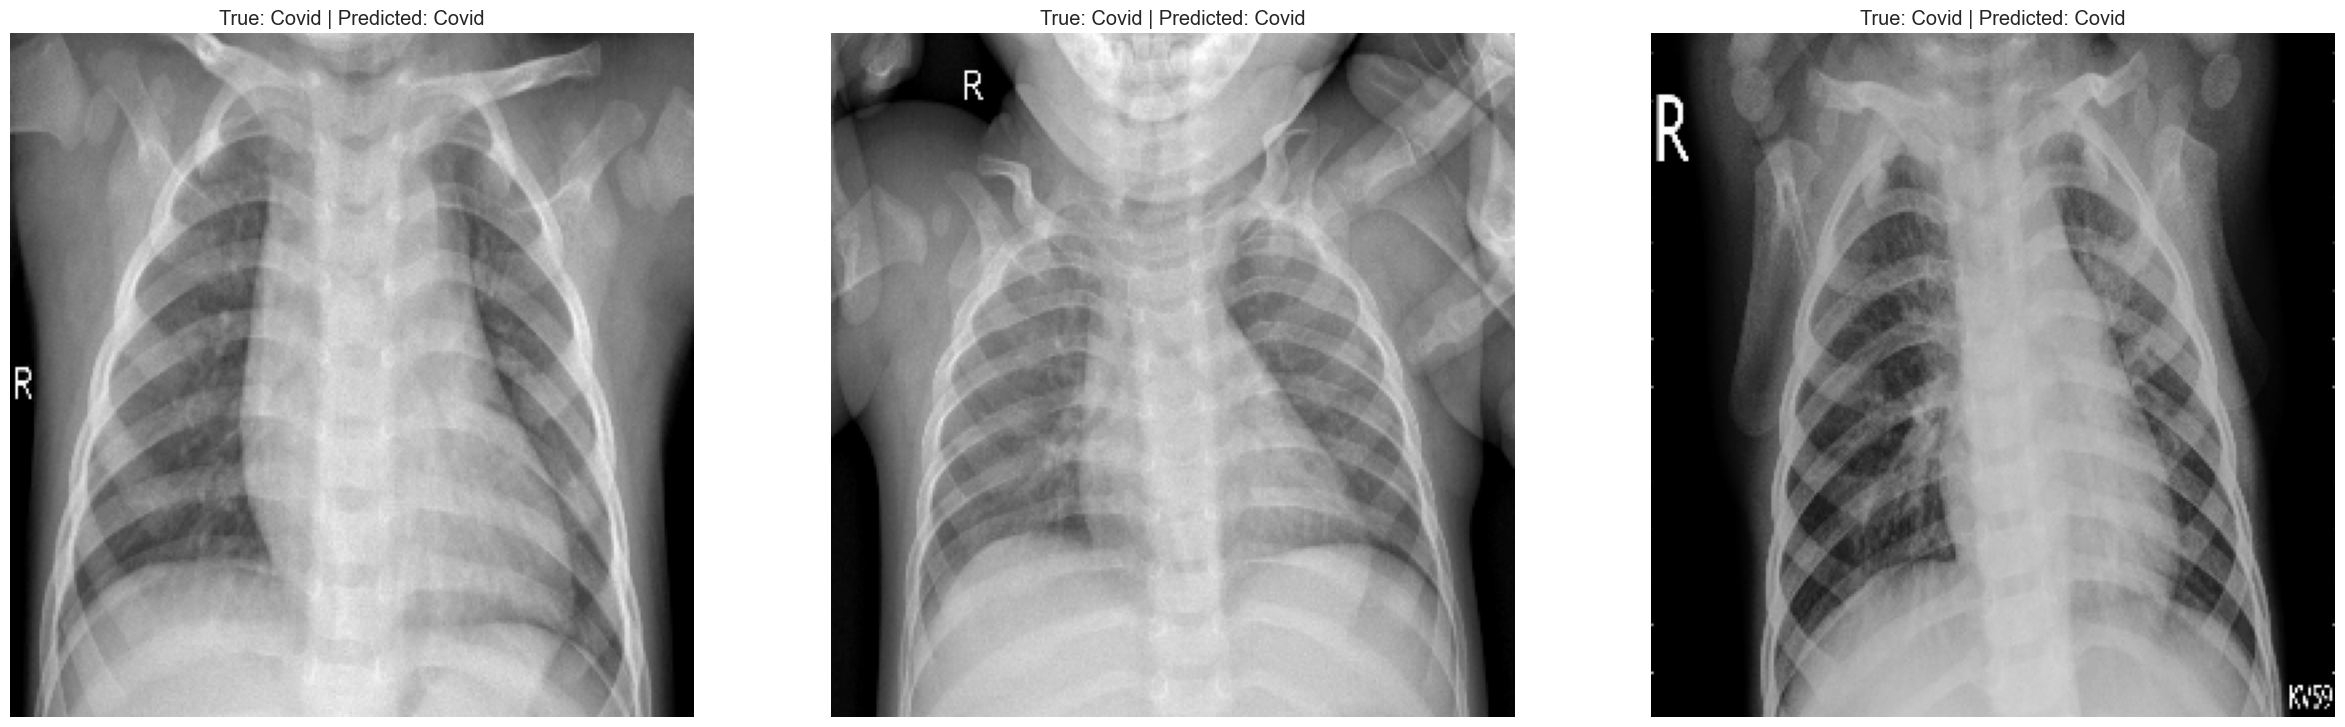

In [16]:
from utils.evaluate_model import evaluate_model
evaluate_model(model, validation_dataset)